In [1]:
import pandas as pd
import numpy as np 
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import adjusted_rand_score as ARI

jitter
0.01    AxesSubplot(0.125,0.125;0.775x0.755)
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.15    AxesSubplot(0.125,0.125;0.775x0.755)
0.20    AxesSubplot(0.125,0.125;0.775x0.755)
0.25    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

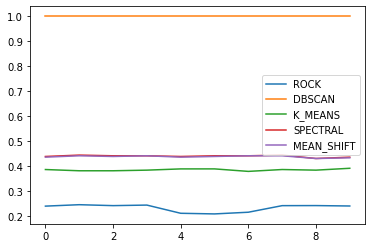

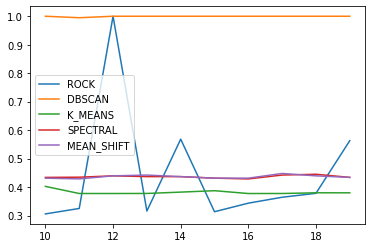

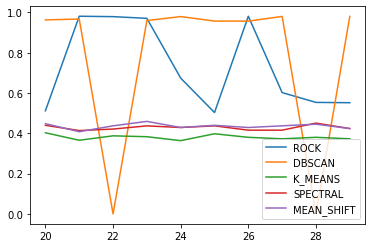

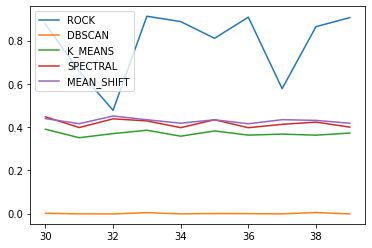

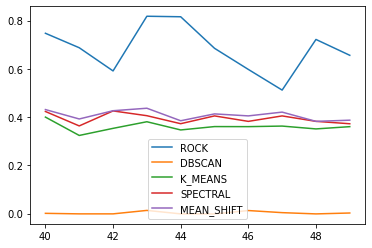

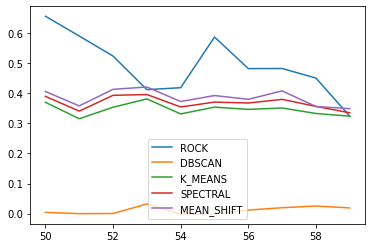

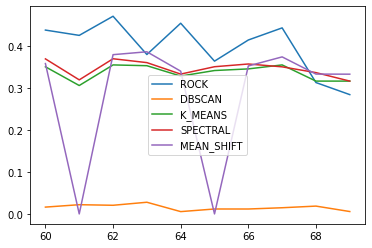

In [2]:
pd.read_csv('two_moons_analysis_jitter.csv').groupby('jitter')[['ROCK', 'DBSCAN', 'K_MEANS', 'SPECTRAL', 'MEAN_SHIFT']].plot()

In [3]:
import optuna
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_mutual_info_score as AMI
from rock import ROCK

from util import dbscan_init

import logging
import sys
from tqdm.notebook import tqdm

In [4]:
seed = 0
n_samples = 1000
jitter = 5 * 0.01
datasets = []
experiment = []

In [5]:
for s in tqdm(range(seed, seed+100)):
    dataset = make_moons(n_samples=n_samples, noise=jitter, shuffle=True, random_state=s) 
    run = {}
    run['seed'] = seed
    run['n_samples'] = n_samples
    run['jitter'] = jitter
    scaler = StandardScaler()
    data = scaler.fit_transform(dataset[0])
    kmeans = KMeans(n_clusters=2, random_state=seed).fit(data).labels_
    run['k'] = 2
    eps, min_pts = dbscan_init(data)
    eps, min_pts = (0.2, 4)
    dbscan = DBSCAN(eps=eps, min_samples=min_pts).fit(data).labels_
    run['eps'] = eps
    run['min_pts'] = min_pts
    spectral = SpectralClustering(n_clusters=2).fit(data).labels_
    bandwidth = estimate_bandwidth(data)

    run['bandwidth'] = bandwidth
    mean_shift = MeanShift(bandwidth=bandwidth).fit(data).labels_

    rock = ROCK(tmax=15).fit(data).labels_

    gt = dataset[1]

    run['ROCK'] = AMI(rock, gt)
    run['K_MEANS'] = AMI(kmeans, gt)
    run['DBSCAN'] = AMI(dbscan, gt)
    run['SPECTRAL'] = AMI(spectral, gt)
    run['MEAN_SHIFT'] = AMI(mean_shift, gt)

    experiment.append(run)

In [6]:
pd.DataFrame(experiment)[['ROCK', 'K_MEANS', 'DBSCAN', 'SPECTRAL', 'MEAN_SHIFT']]

,ROCK,K_MEANS,DBSCAN,SPECTRAL,MEAN_SHIFT
0,0.305714,0.402387,1.000000,0.433986,0.431282
1,0.324892,0.377417,0.994815,0.434660,0.428786
2,1.000000,0.377366,1.000000,0.439457,0.439457
3,0.315822,0.377594,1.000000,0.436711,0.442159
4,0.568282,0.382286,1.000000,0.436695,0.436695
...,...,...,...,...,...
95,0.366361,0.374945,1.000000,0.434307,0.439916
96,0.288982,0.372491,1.000000,0.445618,0.448097
97,0.308502,0.394968,1.000000,0.456152,0.458859
98,1.000000,0.377493,1.000000,0.439523,0.439752


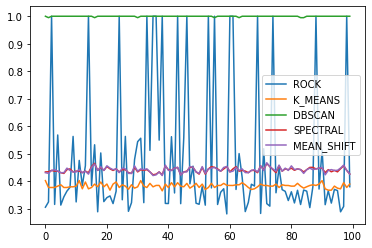

In [7]:
pd.DataFrame(experiment)[['ROCK', 'K_MEANS', 'DBSCAN', 'SPECTRAL', 'MEAN_SHIFT']].plot()

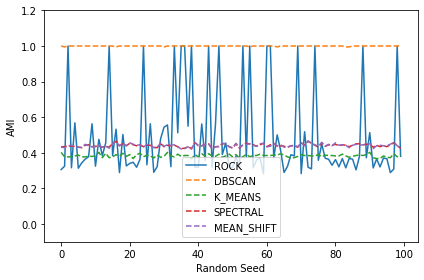

In [31]:
import matplotlib.pyplot as plt

mean_std = pd.DataFrame(experiment)[['ROCK', 'K_MEANS', 'DBSCAN', 'SPECTRAL', 'MEAN_SHIFT']]

plt.plot(mean_std.index, mean_std['ROCK'],  label='ROCK')
plt.plot(mean_std.index, mean_std['DBSCAN'], '--', label='DBSCAN')
plt.plot(mean_std.index, mean_std['K_MEANS'], '--', label='K_MEANS')
plt.plot(mean_std.index, mean_std['SPECTRAL'], '--', label='SPECTRAL')
plt.plot(mean_std.index, mean_std['MEAN_SHIFT'], '--', label='MEAN_SHIFT')


plt.ylim(-0.1, 1.2)
plt.legend()
plt.xlabel('Random Seed')
plt.ylabel('AMI')
plt.tight_layout()
plt.savefig('figures/two_moons_analysis_100_seeds.png')

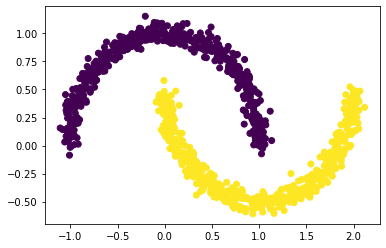

In [8]:
import matplotlib.pyplot as plt


plt.scatter(dataset[0][:, 0], dataset[0][:, 1], c=dataset[1])

plt.savefig('two_moons_normal.png')

In [9]:
dataset = make_moons(n_samples=1000, noise=0.05, shuffle=True, random_state=0) 
scaler = StandardScaler()
data = scaler.fit_transform(dataset[0])
rock = ROCK(tmax=15).fit(data).labels_
print(AMI(rock, dataset[1]))

0.30571381501747225


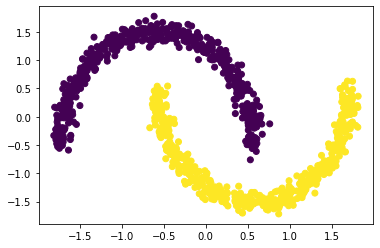

In [10]:
import matplotlib.pyplot as plt


plt.scatter(data[:, 0], data[:, 1], c=dataset[1])

plt.savefig('two_moons_scaled.png')

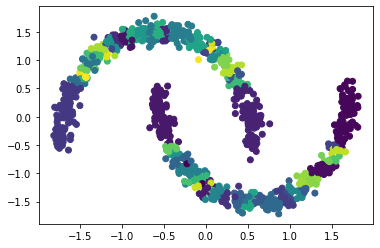

In [11]:
plt.scatter(data[:, 0], data[:, 1], c=rock)
plt.savefig('wtf_scaled.png')